# Walkthrough - RBIG

In [109]:
import sys
sys.path.append("../")

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library parameters
from rbig_jax.data import get_classic
from rbig_jax.information.reduction import information_reduction
from rbig_jax.plots.info import plot_total_corr
from rbig_jax.plots.joint import plot_joint
from rbig_jax.plots.prob import plot_joint_prob
from rbig_jax.transforms.gaussian import init_params
from rbig_jax.transforms.rbig import rbig_init

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


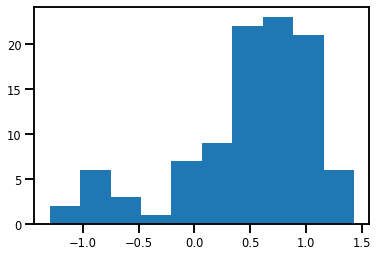

In [110]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

In [3]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


W&B Run: https://app.wandb.ai/emanjohnson91/rbigjax-demo-2d/runs/14gbxdo5

In [4]:

# config parameters
wandb.config.n_samples = 10_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

In [111]:
def plot_joint(data, color: str = "red", title: str = "", kind="kde", logger=None):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

def plot_joint_prob(data, probs, cmap="Reds", title="", logger=None):

    fig, ax = plt.subplots()
    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(h,)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

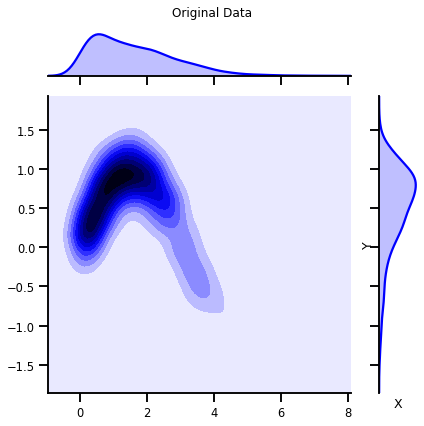

In [112]:
# %%wandb
# get data
data = get_classic(1_000)

# plot data
plot_joint(data, "blue", "Original Data", logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [113]:
from rbig_jax.transforms.rbig import forward_transform, inverse_transform

In [114]:
# get the init function
fit_forward_func = rbig_init(
    method="histogram",
    support_ext=10,
    precision=50,
    alpha=1e-5
)

In [115]:
# fit forward function
Xtrans, ldX, params = fit_forward_func(data)

# forward function
Xtrans_, ldX_ = forward_transform(params, data)

# checks to make sure they're the same
chex.assert_tree_all_close(Xtrans, Xtrans_, rtol=1e-5)
chex.assert_tree_all_close(ldX, ldX_, rtol=1e-5)
chex.assert_shape(Xtrans, (1_000, 2))

<Figure size 432x288 with 0 Axes>

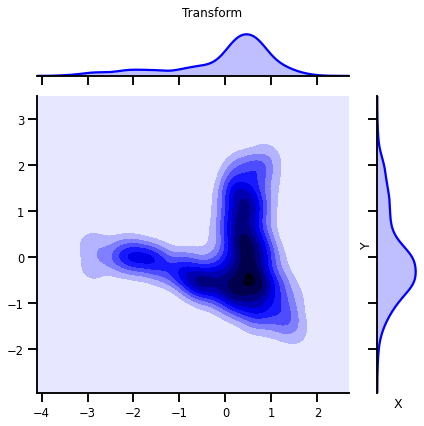

In [116]:
plot_joint(Xtrans, "blue", "Transform", logger=False)

### Inverse Transformation

In [117]:
data_ = inverse_transform(params, Xtrans)

chex.assert_tree_all_close(data_, data, rtol=1e-5)

<Figure size 432x288 with 0 Axes>

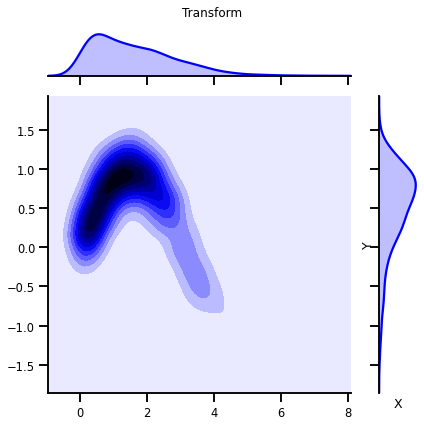

In [118]:
plot_joint(data_, "blue", "Transform", logger=False)

### Speed

We can use the `jit` method to speed up our code considerably. We simply need to jit our forward function and our inverse function.

#### Non-Jitted

In [13]:
%timeit Xtrans, ldX, params = fit_forward_func(data)
%timeit _ = forward_transform(params, data)
%timeit _ = inverse_transform(params, Xtrans)

217 ms ± 4.67 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
560 µs ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
528 µs ± 9.51 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Jitted

In [119]:
# get the init function
fit_forward_func = rbig_init(
    method="histogram",
    support_ext=10,
    precision=100,
    alpha=1e-5
)
fit_forward_func_jitted = jax.jit(fit_forward_func)
Xtrans, ldX, params = fit_forward_func_jitted(data)
forward_func_jitted = jax.jit(forward_transform)
inverse_func_jitted = jax.jit(inverse_transform)

In [15]:
%timeit _ = fit_forward_func_jitted(data)
%timeit _ = forward_func_jitted(params, data)
%timeit _ = inverse_func_jitted(params, Xtrans)

1.07 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
313 µs ± 37.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
189 µs ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Training

So now we have our step function and we need some kinda of condition. We will do 3 conditions:

1. We need a maximum number of layers
2. We need a minimum number of layers
3. We need no changes between a running loss

## State

In [120]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)


## Stopping Criteria

In [121]:
max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 10


def condition_fun(state):
    # stopping criterial
    stop_crit = jax.lax.bitwise_and(
        jax.lax.bitwise_not(state.n_layers < min_layers), 
        state.n_layers > max_layers
    )
    stop_crit = jax.lax.bitwise_not(stop_crit)
    info_sum = np.sum(state.info_loss[state.n_layers:state.n_layers+tol_layers])
    
    info_crit = jax.lax.bitwise_not(bool(int(info_sum)))
    print(stop_crit, info_sum, info_crit)
    return info_crit
#     # information loss criteria
#     if state.n_layers > tol_layers:
#         return stop_crit
#     else:
#         info_crit = state.info_loss[-tol_layers:].sum() == 0.0
#         return np.logical_or(stop_crit, info_crit) 

In [122]:
bool(int(0.0))

False

### Condition 1

We have `n_layers=1`. 

In [123]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)

train_state = TrainState(
    n_layers=0,
    info_loss=np.pad(np.zeros((max_layers,)), (tol_layers,0)),
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
)

condition_fun(train_state)

True 0.0 True


DeviceArray(True, dtype=bool)

#### Condition 2

In [124]:
train_state = TrainState(
    n_layers=15,
    info_loss=np.pad(np.zeros((max_layers,)), (tol_layers,0)),
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
)

condition_fun(train_state)

True 0.0 True


DeviceArray(True, dtype=bool)

#### Condition 3

In [125]:
train_state = TrainState(
    n_layers=150,
    info_loss=np.pad(np.zeros((max_layers,)), (tol_layers,0)),
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

condition_fun(train_state)

False 0.0 True


DeviceArray(True, dtype=bool)

In [126]:
# tol_zeros = 2

# t = np.concatenate([np.ones(10), np.zeros(5)])
# t_padded = np.pad(t, (tol_zeros-1, 0))

# t_padded

In [127]:
# for i in range(t.shape[0]):
#     print(i)
#     # select window
#     window = t_padded[i:i+tol_zeros]
    
#     # take the sum
#     window_sum = np.sum(window)
#     print(f"Layer: {i}, Sum: {window_sum}")

In [128]:
# itms = [10, 5, 2, 1, 0, 0, 0, 0, 0, 0]
# max_layers = len(itms)

# its = []

### 3 - Training Loop

In [129]:
# t = np.pad(np.zeros((max_layers,)), (tol_layers,0))
# np.zeros((max_layers,)).shape, t.shape

In [130]:
data = get_classic(10_000)

max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 10


def condition_fun(state):
    # stopping criterial
    stop_crit = jax.lax.bitwise_and(
        jax.lax.bitwise_not(state.n_layers < min_layers), 
        state.n_layers > max_layers
    )
    stop_crit = jax.lax.bitwise_not(stop_crit)
    info_sum = np.sum(state.info_loss[state.n_layers:state.n_layers+tol_layers])
    
    info_crit = info_sum > 0.0
    print(info_sum, info_crit)
    return info_crit
# data = np.array(onp.random.randn(10_000, 10))

init_loss = np.pad(np.zeros((max_layers,)), (tol_layers-1,0))
init_loss = jax.ops.index_update(train_state.info_loss, tol_layers, 1.0)
train_state = TrainState(
    n_layers=0,
    info_loss=init_loss,
    params=[],
    X=data,
    Xldj=np.zeros(data.shape)
    
)

it_jitted = jax.jit(information_reduction)

def body(train_state):
    X, Xldj, params = fit_forward_func(train_state.X)

    # calculate the information loss
    it = information_reduction(train_state.X, X)

    # update the train state
    train_state = TrainState(
        n_layers=train_state.n_layers + 1,
        info_loss=jax.ops.index_update(train_state.info_loss, tol_layers + train_state.n_layers, it),
        params=train_state.params + [params],
        X=X,
        Xldj=train_state.Xldj + Xldj
    )
#     print(it, condition_fun(train_state))
    return train_state

In [107]:
jax.lax.bitwise_not(0.01 > 0.0)

DeviceArray(False, dtype=bool)

In [131]:

def loss_func(X, X_log_det):
    # calculate probability
    log_prob = jax.scipy.stats.norm.logpdf(X).sum(axis=1)
    
    likelihood = log_prob + X_log_det.sum(axis=1)
    # log likelihood
    return - likelihood.mean()

In [132]:
from collections import namedtuple

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
        "info_loss", # information loss
        "params",
        "X",
        "Xldj"
    ]
)

print(tol_layers)

def init_state(X: np.ndarray, stopping_criteria: str="info", tol_layers: int=10, min_layers: int=10, max_layers: int=1_000):
    
    # initialize loss vector

    
    # initialize train state
#     print(tol_layers)

    if stopping_criteria == "info":
        
        # init loss with stopping criteria
        init_loss = np.pad(np.zeros((max_layers,)), (tol_layers,0))
        init_loss = jax.ops.index_update(init_loss, np.arange(0, tol_layers, dtype=int), 1.0)
        train_state = TrainState(
            n_layers=0,
            info_loss=init_loss,
            params=[],
            X=X,
            Xldj=np.zeros(X.shape)

        )
        def condition_func(state):
            
            layers = state.info_loss[state.n_layers:tol_layers + state.n_layers]
#             plt.figure()
#             plt.plot(np.linspace(state.n_layers, tol_layers + state.n_layers, num=len(layers)), layers)
#             plt.show()
            info_sum = np.sum(np.abs(layers))
#             print(state.n_layers, tol_layers + state.n_layers, info_sum)
            info_crit = info_sum > 0.0
            return info_crit
#             t = jax.lax.cond(
#                 info_sum > 0.0,
#                 info_sum, lambda x: True,
#                 info_sum, lambda x: False)
#             return t
        
#         return train_state, condition_func
    
    elif stopping_criteria == "max":
        # init loss with
        train_state = TrainState(
            n_layers=0,
            info_loss=np.zeros((max_layers,)),
            params=[],
            X=X,
            Xldj=np.zeros(X.shape)

        )
        def condition_func(state):
            # stopping criteria
            stop_crit = jax.lax.bitwise_and(
                jax.lax.bitwise_not(state.n_layers < min_layers), 
                state.n_layers > max_layers
            )
            stop_crit = jax.lax.bitwise_not(stop_crit)

            return stop_crit
        
#         return train_state, condition_func
    else:
        raise ValueError(f"Unrecognized stopping_criteria: {stopping_criteria}")
        
    def body(state):
        X, Xldj, params = fit_forward_func_jitted(state.X)

        # calculate the information loss
        it = information_reduction(state.X, X)
#         print("UPDATE:", tol_layers + state.n_layers)

        # update the train state\
#         print(tol_layers)
        state = TrainState(
            n_layers=state.n_layers + 1,
            info_loss=jax.ops.index_update(state.info_loss, tol_layers + state.n_layers, it),
            params=state.params + [params],
            X=X,
            Xldj=state.Xldj + Xldj
        )
    #     print(it, condition_fun(train_state))
        return state
    
    return train_state, condition_func, body



# print("InitLoss Shape:", init_loss.shape)
# train_state = TrainState(
#     n_layers=0,
#     info_loss=init_loss,
#     params=[],
#     X=data,
#     Xldj=np.zeros(data.shape)
    
# )
# condition_fun(train_state)

10


In [133]:
# tol_layer = 50

# train_state, cond_func = init_state(data, "info", tol_layers=tol_layers)

# def body(train_state):
#     X, Xldj, params = fit_forward_func_jitted(train_state.X)

#     # calculate the information loss
#     it = information_reduction(train_state.X, X)
#     print("UPDATE:", tol_layers + state.n_layers)

#     # update the train state
#     state = TrainState(
#         n_layers=state.n_layers + 1,
#         info_loss=jax.ops.index_update(state.info_loss, tol_layers + state.n_layers, it),
#         params=state.params + [params],
#         X=X,
#         Xldj=state.Xldj + Xldj
#     )
# #     print(it, condition_fun(train_state))
#     return state

In [135]:
%%time
tol_layers = 10
data = get_classic(10_000)
# data = np.array(onp.random.randn(100_000, 100))
train_state, cond_func, body = init_state(data, "info", tol_layers=tol_layers)


while cond_func(train_state):
#     print(train_state.n_layers)
    train_state = body(train_state)
    
#     loss = loss_func(train_state.X, train_state.Xldj)
#     losses.append(loss)

CPU times: user 1min 43s, sys: 13.2 s, total: 1min 57s
Wall time: 9.76 s


In [136]:
def information_loss(state):
    return train_state.info_loss[tol_layers:tol_layers+train_state.n_layers]

In [137]:
info_loss = information_loss(train_state)
print(train_state.n_layers)

22


Text(0.5, 1.0, 'Information Loss, n=22')

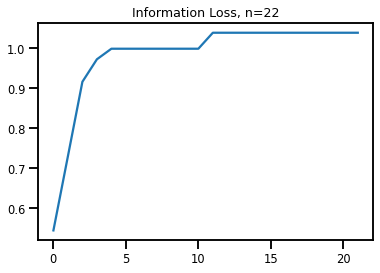

In [138]:
plt.plot(np.cumsum(np.array(info_loss)))
plt.title(f"Information Loss, n={train_state.n_layers}")

<Figure size 432x288 with 0 Axes>

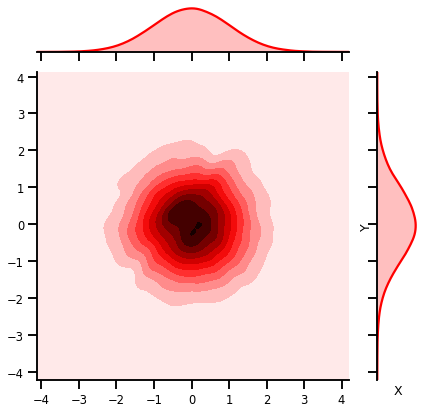

In [139]:
plot_joint(train_state.X)

### Invertible

In [170]:
from typing import List


def rbig_inverse_transform(X: np.ndarray, params: List) -> np.ndarray:
#     init_val = X
    for iparam in reversed(params):
        X = inverse_func_jitted(iparam, X)
#         init_val = X
    return X

t0 = time.time()

data_approx = rbig_inverse_transform(train_state.X, train_state.params)
print(f"Time Taken: {(time.time() - t0):.4f}")

# check that the forward and inverse are close
chex.assert_tree_all_close(data, data_approx)

Time Taken: 0.0072


In [164]:
chex.assert_tree_all_close(data, data_approx, rtol=1e-9)

In this particular example, I was able to get it up to a maximum tolerance of 1e-9. This is pretty good.

In [156]:
%timeit _ = rbig_inverse_transform(train_state.X, train_state.params)

60 ms ± 361 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<Figure size 432x288 with 0 Axes>

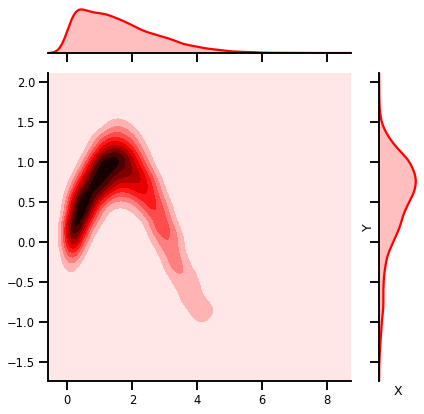

In [159]:
plot_joint(data_approx)

In [ ]:
t0 = time.time()
init_val = train_state.X
for iparam in reversed(train_state.params):
    X = inverse_func_jitted(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")

### Forward Transformation

In [ ]:
data_new = 

In [59]:
import time
t0 = time.time()
init_val = data
for iparam in train_state.params:
    X, _ = forward_transform(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")
    
t0 = time.time()
init_val = data
for iparam in train_state.params:
    X, _ = forward_func_jitted(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")

Time Taken: 0.4648
Time Taken: 0.7312


<Figure size 432x288 with 0 Axes>

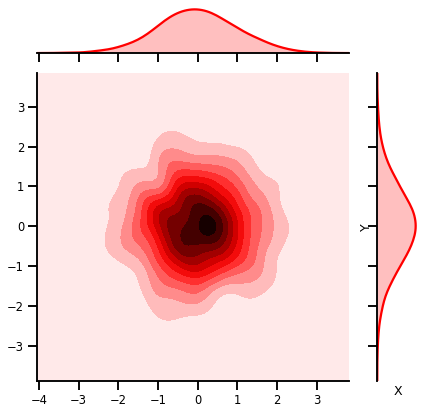

In [60]:
plot_joint(init_val)

#### Reverse Transformation

In [61]:
t0 = time.time()
init_val = train_state.X
for iparam in reversed(train_state.params):
    X = inverse_transform(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")


t0 = time.time()
init_val = train_state.X
for iparam in reversed(train_state.params):
    X = inverse_func_jitted(iparam, init_val)
    init_val = X
print(f"Time Taken: {(time.time() - t0):.4f}")



Time Taken: 0.4054
Time Taken: 0.3998


<Figure size 432x288 with 0 Axes>

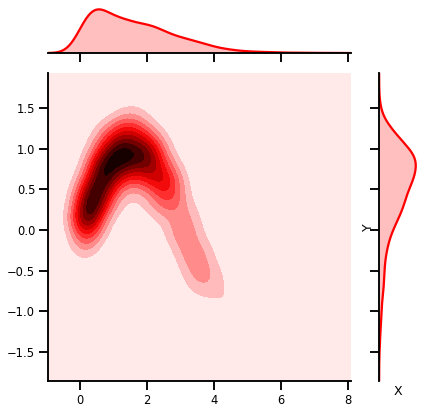

In [62]:
plot_joint(init_val)

In [63]:
train_state.n_layers

12